# Setup
Universe - Nifty-Futures  
Time frame - 15 minutes

## Rules
- MARK HIGH-LOW OF FIRST 15 MIN. CANDLE
- NEXT 4 CANDLE SHOULD CLOSE INSIDE THE FIRST 15 MINUTE RANGE
- POST 4 CANDLE, IF MARKET CLOSE BELOW LOW OF RANGE, WE SHORT AND KEEP HIGH AS STOPLOSS
- POST 4 CANDLE, IF MARKET CLOSE ABOVE HIGH OF RANGE, WE LONG AND KEEP LOW AS STOPLOSS
- INTRADAY EXIT AT 15:15

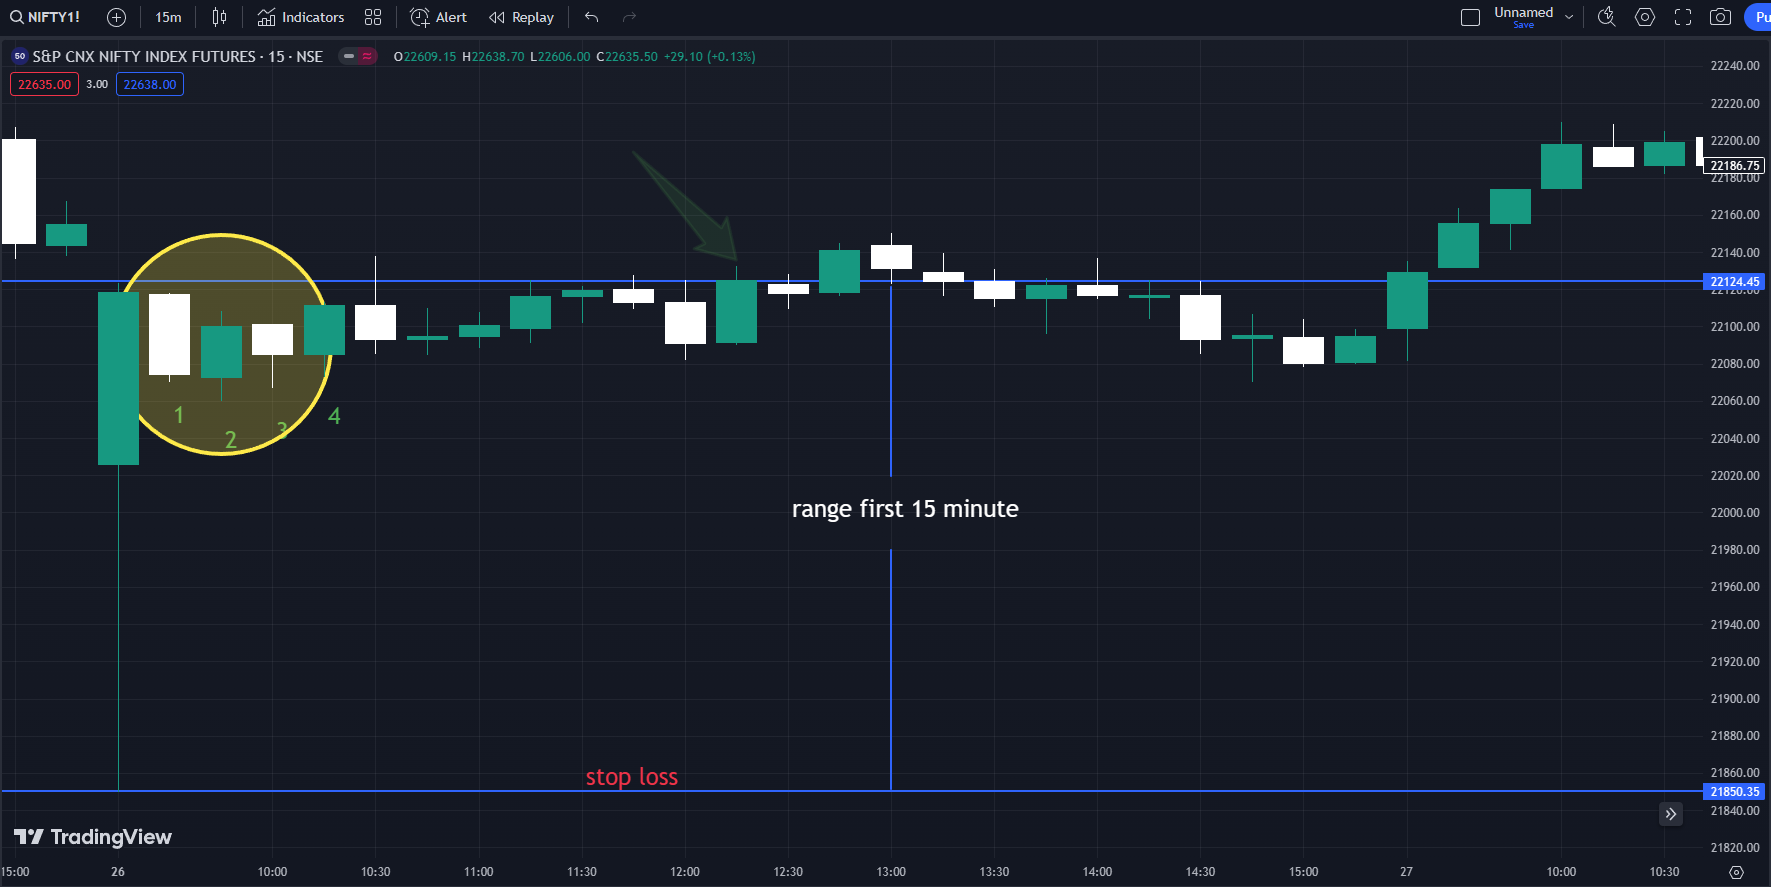

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import openpyxl
import pandas_ta as ta
import sys
sys.path.append (r"C:\TheG\codes\codes")
import self_code as sc
import Utils as ut
import glob
import warnings
warnings.filterwarnings("ignore")

- Note: self_code is private library of BALYSIS pvt. ltd.  
If you want the same, please mail to black3shorts@gmail.com or founder@balysis.in

### Importing data from csv

In [2]:
# import data from local
nifty = pd.read_csv(r"C:\Indian Data\Futures\NIFTY-FUT1.csv")

In [3]:
nifty

,datetime,open,high,low,close,volume,symbol
0,01-01-2019 09:15,10909.95,10929.90,10908.45,10910.20,33750,31-01-2019
1,01-01-2019 09:16,10911.00,10916.80,10908.05,10912.10,15300,31-01-2019
2,01-01-2019 09:17,10911.35,10911.35,10910.95,10910.95,4275,31-01-2019
3,01-01-2019 09:18,10898.35,10898.35,10893.10,10897.00,3525,31-01-2019
4,01-01-2019 09:19,10896.00,10896.00,10870.45,10872.15,123525,31-01-2019
...,...,...,...,...,...,...,...
469522,25-01-2024 15:25,21345.20,21348.85,21344.30,21348.85,25050,25-01-2024
469523,25-01-2024 15:26,21346.00,21349.00,21345.05,21349.00,17250,25-01-2024
469524,25-01-2024 15:27,21348.80,21350.50,21347.05,21350.00,18500,25-01-2024
469525,25-01-2024 15:28,21350.00,21352.00,21348.10,21350.00,14250,25-01-2024


### Resample to 15 minute time frame

In [4]:
# Resampling is done here from 1 minute to 15 minute time frame
nifty = sc.resample(nifty, '15min')

In [5]:
nifty

,open,high,low,close,volume
datetime,,,,,
2019-01-01 09:15:00,10909.95,10929.90,10864.00,10883.00,597525
2019-01-01 09:30:00,10882.00,10883.00,10868.00,10878.00,221700
2019-01-01 09:45:00,10878.00,10882.90,10853.00,10853.65,375675
2019-01-01 10:00:00,10854.65,10859.00,10843.20,10857.35,379800
2019-01-01 10:15:00,10857.10,10865.65,10851.85,10865.05,147375
...,...,...,...,...,...
2024-01-25 14:15:00,21273.00,21285.00,21260.00,21280.45,191400
2024-01-25 14:30:00,21280.80,21295.50,21255.10,21265.15,268950
2024-01-25 14:45:00,21265.15,21277.25,21261.60,21270.55,158700


### Backtesting

In [6]:
# variable initialisation
status = 0
entry_price = 0
entry_time = 0
exit_price = 0
exit_time = 0
target = 0
pnl = pd.DataFrame(columns = ['Type', 'Entry Price', 'Entry Time', 'Exit Price', 'Exit Time', 'Points', 'Pnl'])

# backtest code
for row, value in nifty.iterrows():
    if status == 0 and str(row.time()) == '09:15:00':
        status = 'got range'
        mx = value['high']
        mn = value['low']
        continue
    elif status == 'got range' and str(row.time()) in ['09:30:00','09:45:00','10:00:00','10:15:00']:
        if mx >= value['close'] >= mn:
            continue
        else:
            status = 0
            continue
    elif status == 'got range' and value['close'] >= mx:
        status = 'long trade'
        entry_price = value['close']
        entry_time = row
        continue
    elif status == 'got range' and value['close'] <= mn:
        status = 'short trade'
        entry_price = value['close']
        entry_time = row
        continue
    elif status == 'long trade' and str(row.time()) == '15:15:00':
        status = 0
        pnl.loc[len(pnl)] = ['Long', entry_price, entry_time, value['open'], row, (value['open'] - entry_price), (value['open'] - entry_price) * 50]
        continue
    elif status == 'short trade' and str(row.time()) == '15:15:00':
        status = 0
        pnl.loc[len(pnl)] = ['Short', entry_price, entry_time, value['open'], row, (entry_price - value['open']), (entry_price - value['open']) * 50]
        continue
    elif status == 'long trade' and value['high'] >= mn >= value['low']:
        status = 0
        pnl.loc[len(pnl)] = ['Long', entry_price, entry_time, mn, row, (mn - entry_price), (mn - entry_price) * 50]
        continue
    elif status == 'short trade' and value['high'] >= mx >= value['low']:
        status = 0
        pnl.loc[len(pnl)] = ['Short', entry_price, entry_time, mn, row, (entry_price - mx), (entry_price - mx) * 50]
        continue

In [8]:
pnl

,Type,Entry Price,Entry Time,Exit Price,Exit Time,Points,Pnl
0,Short,10880.00,2019-01-09 10:30:00,10881.70,2019-01-09 15:15:00,-1.70,-85.0
1,Short,10860.00,2019-01-10 11:00:00,10859.45,2019-01-10 15:15:00,0.55,27.5
2,Short,10925.00,2019-01-17 10:30:00,10928.70,2019-01-17 14:45:00,-23.95,-1197.5
3,Long,10953.75,2019-01-23 12:00:00,10925.00,2019-01-23 13:30:00,-28.75,-1437.5
4,Short,10832.35,2019-01-24 12:30:00,10833.50,2019-01-24 15:00:00,-37.65,-1882.5
...,...,...,...,...,...,...,...
322,Long,21116.60,2023-12-12 09:15:00,21046.60,2023-12-12 13:00:00,-70.00,-3500.0
323,Short,21709.15,2023-12-28 10:45:00,21711.05,2023-12-28 11:00:00,-51.00,-2550.0
324,Short,21752.20,2024-01-05 10:45:00,21800.85,2024-01-05 15:15:00,-48.65,-2432.5
325,Long,21641.95,2024-01-10 14:30:00,21693.50,2024-01-10 15:15:00,51.55,2577.5


### Metric generation

In [10]:
sc.final(pnl, r"C:\work\balysis\Youtube\Backtest Verification\Ghanshaym trader\result.xlsx", capital = 150000)